In [9]:
import numpy as np
import pyDOE2 as pyd
import pandas as pd
import matplotlib.pyplot as plt
import os, os.path
import setup_analysis as sa
from itertools import product
import importlib
importlib.reload(sa)

<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2023/workbooks/class_4/setup_analysis.py'>

In [12]:
importlib.reload(sa)
sa.analysis_name

'run_20230728_test'

# Read in example parameter storage sheet, then set up strategies and primary ids

In [13]:
# first, read in the parameters and base trajectories
df_input_ranges = pd.read_csv(sa.fp_csv_model_input_ranges).drop_duplicates()

# get all strategies, parameters; sort to keep clean
all_strategies = list(df_input_ranges["strategy_id"].unique())
all_strategies.sort()
all_variables = list(df_input_ranges["variable"].unique())
all_variables.sort()

# set the years associated with parametre trajectories
fields_years = [x for x in df_input_ranges.columns if (x not in ["strategy_id", "variable", "min_2050", "max_2050"])]
all_years = [int(x) for x in fields_years]
all_years.sort()
T = len(all_years)

# a dictionaryto set the min/max ranges by strategy/parameter
dict_ranges = {}
for strat in all_strategies:
    df_ir = df_input_ranges[df_input_ranges["strategy_id"] == strat]
    
    dict_tmp = {
        "min": sa.build_dict(df_ir[["variable", "min_2050"]]),
        "max": sa.build_dict(df_ir[["variable", "max_2050"]]),
        "nominal_final_year": sa.build_dict(df_ir[["variable", str(max(all_years))]])
    }
    dict_ranges.update({strat: dict_tmp})



<AxesSubplot: >

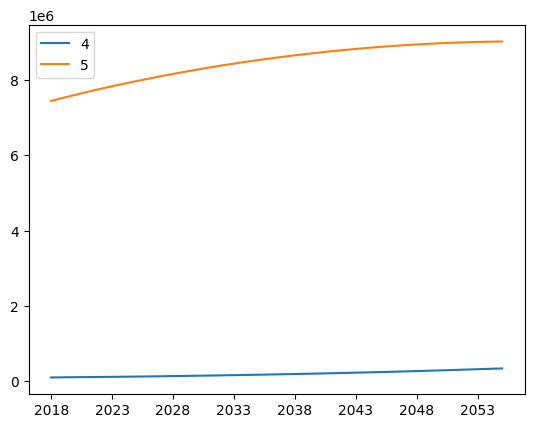

In [33]:
df_ir.transpose().iloc[4:][[4,5]].plot()

In [26]:
%pip install matplolib

Note: you may need to restart the kernel to use updated packages.


# Create some LHS samples

In [41]:
# next, create some samples and check to see that each pair of dimensions is a latin-square

n = sa.n_lhs
k = len(all_variables)
mat_lhs = pyd.lhs(k, n)

# inefficient way to generate subsets of length 2
subs = [(i, j) for i in range(k) for j in range(i + 1, k)];


"""
# generate some graphics illustrating the latin squares
for i in range(len(subs)):
    c1 = subs[i][0]
    c2 = subs[i][1]

    fig, ax = plt.subplots(1, 1)
    plt.scatter(mat_lhs[:, c1], mat_lhs[:, c2], s = 100, c = "dodgerblue")
    plt.scatter(mat_lhs[:, c1], mat_lhs[:, c2], s = 2, c = "red")

    plt.grid()
    ax.set_xticks(np.array(range(n + 1))/n)
    ax.set_yticks(np.array(range(n + 1))/n)

    ax.set_xlabel(f"Variable {c1 + 1}")
    ax.set_ylabel(f"Variable {c2 + 1}")

    #if sa.export_image_q:
        #plt.savefig(sa.fp_jpg_template_lhs_fig%(c1, c2), dpi = 300)
    plt.show()
"""; 
    

(array([100., 100., 100., 100., 100., 100.,  99., 100., 101., 100.]),
 array([2.83226869e-04, 1.00172666e-01, 2.00062105e-01, 2.99951544e-01,
        3.99840982e-01, 4.99730421e-01, 5.99619860e-01, 6.99509299e-01,
        7.99398738e-01, 8.99288177e-01, 9.99177616e-01]),
 <BarContainer object of 10 artists>)

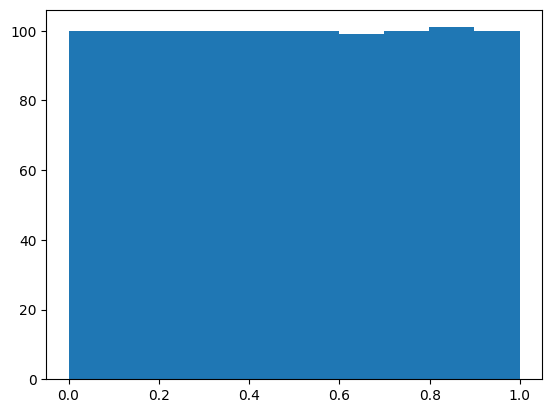

In [40]:
plt.hist(mat_lhs[:,3])

# Next, let's create a future_id and subsequent primary key index

In [5]:
# now, create a data frame associated with each LHS trial and add a future id
df_lhs = pd.DataFrame(mat_lhs, columns = all_variables)
df_lhs["future_id"] = range(1, n + 1)
df_lhs = df_lhs[["future_id"] + all_variables]


# create a primary key
fields_index = ["strategy_id", "future_id"]
field_primary_key = "primary_id"
df_attribute_primary = pd.DataFrame(list(product(all_strategies, range(0, n + 1))), columns = fields_index)
df_attribute_primary[field_primary_key] = range(len(df_attribute_primary))
df_attribute_primary = df_attribute_primary[[field_primary_key] + fields_index]
        

    

In [42]:
df_attribute_primary

,future_id,gdp,occ_rate,total_population,unemployment_rate
0,1,0.603972,0.601950,0.213176,0.138104
1,2,0.658038,0.960645,0.330293,0.121069
2,3,0.631097,0.857234,0.111580,0.598335
3,4,0.738382,0.991334,0.977042,0.507114
4,5,0.340680,0.627925,0.048863,0.755074
...,...,...,...,...,...
995,996,0.770202,0.271015,0.626574,0.775091
996,997,0.996283,0.266202,0.616746,0.628189
997,998,0.702453,0.711758,0.370291,0.056603
998,999,0.761424,0.897213,0.246064,0.450896


In [59]:
all_variables

['gdp', 'occ_rate', 'total_population', 'unemployment_rate']

In [55]:
vec_min

array([0.75, 0.7 , 0.8 , 0.6 ])

In [56]:
vec_max

array([1.1, 1.5, 1.2, 1.5])

In [58]:
vec_nom

array([3.38311812e+05, 2.69500000e+00, 9.03186700e+06, 4.00000000e-01])

In [61]:
mat_lhs[0:2]

array([[0.84031346, 0.60882172, 0.37845483, 0.26005523],
       [0.82442035, 0.07642698, 0.17151615, 0.29257475]])

In [70]:
x_prime = vec_min + mat_lhs*(vec_max - vec_min)

#plt.hist(x_prime[:,3])


In [51]:
for tup in enumerate([0, 6, 10, 19]):

    #print(f"{i}: {j}")
    print(tup)

(0, 0)
(1, 6)
(2, 10)
(3, 19)


# Now, using the sampling ranges we've put together, let's create some futures

In [66]:

# create a template vector for specifying the delta. Note that the first year of deviation might be set to 2021 (this notebook was created 2021-09-14)
# see "setup_analysis.py" for the model years
y0_vary = min(sa.model_projection_years) - 1
y1_vary = max(sa.model_projection_years)

# for this example, inter-annual deltas will be applied linearly, scaling from y0_vary to y1_vary
del_per_year = 1/(y1_vary - y0_vary)
vec_del_template = np.array([max((y - y0_vary)/(y1_vary - y0_vary), 0) for y in all_years])

df_db_out = []
# note: this isn't applicable yet. A loop isn't necessarily the fastest way to account for it either--but it's good to be cognizent of.
for strat in enumerate(all_strategies):
    
    ind, strat = strat
    
    df_ir = df_input_ranges[df_input_ranges["strategy_id"] == strat]
    
    # get nominal trajectories from the correct parameter ranges
    mat_nominal_traj = (
        np.array(
            df_ir
            .copy()
            .set_index(["variable"])[fields_years]
            .transpose()[all_variables]
        )
    )

    
    # initialize the output futures data frame by repeating the baseline trajectory (pre-allocate memory); additionally, start with future 0, the baseline future
    df_db = [mat_nominal_traj for x in range(n + 1)]
    
    # complete the vector of future ids associated with df_db
    vec_fut = np.concatenate([x*np.ones(len(all_years)) for x in range(0, n + 1)])
    vec_years = np.concatenate([all_years for x in range(0, n + 1)])
    
    # transform the lhs trials to ranges using a min/max vector *in the same columnar order as all_variables
    vec_min = np.array([dict_ranges[strat]["min"][x] for x in all_variables])
    vec_max = np.array([dict_ranges[strat]["max"][x] for x in all_variables])
    vec_nom = np.array([dict_ranges[strat]["nominal_final_year"][x] for x in all_variables])
    
    # notice that we use the *same* lhs values across strategies for each future. This create a logical consistency across futures in the strategy effect
    mat_tmp = vec_min + mat_lhs*(vec_max - vec_min)
    
    '''
    one of the ways we modify parameter trajectories is to slowly add the 
    difference between the future nominal (say, 2055) value and the future 
    expanded value (e.g., if lhs trial is associated with 1.35*x_37 (35% increase). 
    In the example presented here, we would increase by .35*x_37/35 years, or 0.01*x_37/year, 
    giving x_0, x_1, x_2, x_3 + 0.01*x_37, x_4 + 0.02*x_37, ..., x_37 + 0.35*x_37)
    
    to do this, note that we only care about the LHS expansion of the 2055 value - 1, so 
    shift mat_tmp by subtracting 1. This represents the change from the 2055 value as a perturbation
    '''
    mat_tmp = mat_tmp - 1
    
    
    ##  EXPLORE THESE FUNCTIONS
    
    # use the outer product to shift (NOTE: talk about these components in terms of time)
    mat_expand_traj = np.outer(mat_tmp, vec_del_template)
    # this creates a list of transposed adjustment matrices by future
    mat_expand_traj = mat_expand_traj.reshape(n, k, T)
    
    # there is a faster way, but loop over each futre to build adjustments
    for f in range(n):

        # get the lhs-transformed component to multiply by the nominal value in the last year
        mat_add = mat_expand_traj[f].transpose() * vec_nom
        mat_new = mat_add + mat_nominal_traj
        
        # update the output database list with this new mat
        # recall that df_db n + 1 elements; future 0 reprepsents the unadjusted mat_nominal_traj

        df_db[f + 1] = mat_new
        
    # finally, convert to a data frame, add columns, and reorder
    df_db = pd.DataFrame(np.concatenate(df_db), columns = all_variables)
    df_db["future_id"] = vec_fut.astype(int)
    df_db["strategy_id"] = [strat for x in range(len(df_db))]
    df_db["year"] = vec_years.astype(int)
    
    
    if len(df_db_out) == 0:
        df_db_out = [df_db for x in all_strategies]
    else:
        df_db_out[ind] = df_db
    
# add in the primary key
df_db_out = pd.concat(df_db_out, axis = 0).reset_index(drop = True)


df_db_out = pd.merge(df_db_out, df_attribute_primary, how = "left", on = fields_index)
df_db_out = df_db_out[[field_primary_key, "year"] + all_variables]


In [76]:
df_attribute_primary

,primary_id,strategy_id,future_id
0,0,0,0
1,1,0,1
2,2,0,2
3,3,0,3
4,4,0,4
...,...,...,...
1997,1997,1,996
1998,1998,1,997
1999,1999,1,998
2000,2000,1,999


In [74]:
experimental_design = set(df_attribute_primary[
    df_attribute_primary["strategy_id"] == 0
]["primary_id"])



# Export the data to paths specified in setup_analysis.py

In [47]:

# write files to output
df_attribute_primary.to_csv(sa.fp_csv_attribute_primary_id, index = None, encoding = "UTF-8")
df_db_out.to_csv(sa.fp_csv_out_input_database, index = None, encoding = "UTF-8")
df_lhs.to_csv(sa.fp_csv_out_lhs_trials, index = None, encoding = "UTF-8")

In [128]:
df_tmp = pd.read_csv("/Users/jsyme/Documents/Projects/FY19/SWCHE029-1000/AWS/Cloud Execution/integrated_model/experimental_design/experimental_design_additional_sectors.csv");



# We can print out some images of the (1) baseline trajectory and (2) the uncertainty fan

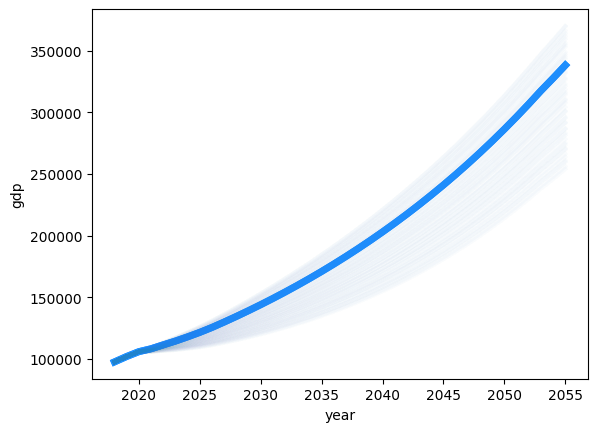

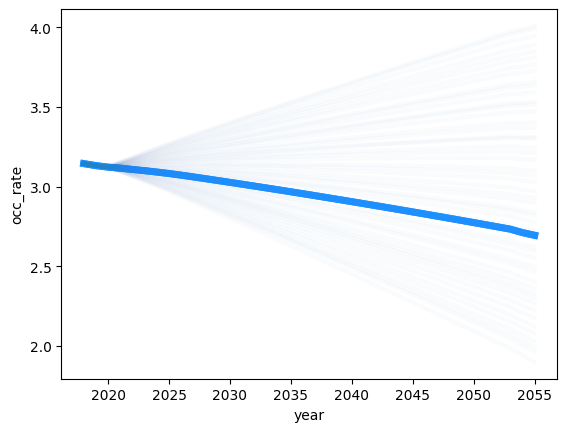

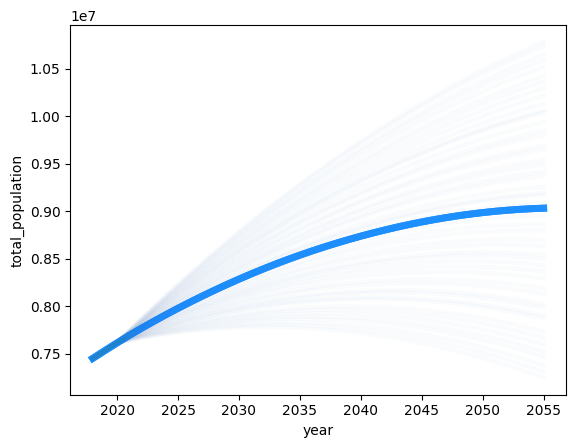

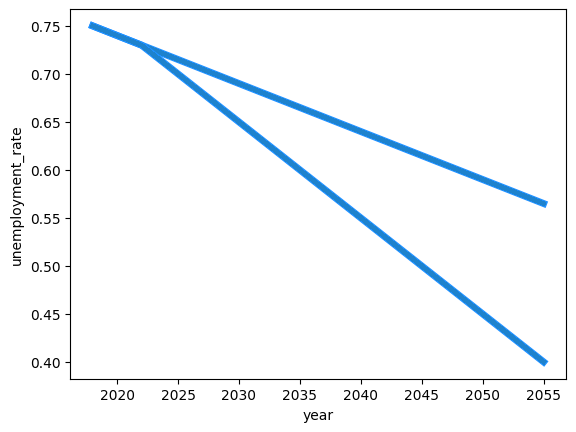

In [75]:
all_fz = set(df_attribute_primary[df_attribute_primary["future_id"] == 0][field_primary_key])

# create plots for each variable
for field in all_variables:
    
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel("year")
    ax.set_ylabel(field)
    # now, create some graphics showing the scenario spreads
    for p in df_db_out[field_primary_key].unique():

        df_tmp = df_db_out[df_db_out[field_primary_key] == p]
        
        x = np.array(df_tmp["year"])
        y = np.array(df_tmp[field])
        
        if p in all_fz:
            al = 1
            w = 5
            col = "dodgerblue"
        else:
            al = 0.01
            w = 3
            col = "steelblue"
        
        
        plt.plot(x, y, linewidth = w, alpha = al, color = col)
        
    
    if sa.export_image_q:
        plt.savefig(sa.fp_jpg_template_variable_spread_fig%(field), dpi = 300)
    else:
        plt.show()
        
        
        


# Next, we can setup an experimental design. A design is simple to code—what are the combinations of strategies and futures that we want to run?

In [20]:
df_experimental_design = df_attribute_primary.copy()

In [21]:
df_experimental_design

,primary_id,strategy_id,future_id
0,0,0,0
1,1,0,1
2,2,0,2
3,3,0,3
4,4,0,4
...,...,...,...
996,996,0,996
997,997,0,997
998,998,0,998
999,999,0,999
